# Intro
This quick and dirty kernel shows how to implement a dilated conv network segmenting nuclei using a neural network in Keras.  This is based on a kernel from  [Kaggle](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) which uses the popular [U-Net](https://arxiv.org/abs/1505.04597) implementation for semantic segmentation.

The architecture we are using is a convolutional network with [dilated convolutions](https://arxiv.org/abs/1511.07122), which is a method of convolution that allows for a larger receptive field while only slowly increasing the number of required parameters. A good visualization of a dilated convolution is found on [github](https://github.com/vdumoulin/conv_arithmetic). Finally a good blog post to learn about semantic segmentation is found on the [qure.ai blog](http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review).

Let's get started importing everything we need!

In [13]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BASE_PATH = os.getcwd()
TRAIN_PATH = BASE_PATH+'/input/stage1_train/'
TEST_PATH = BASE_PATH+'/input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [14]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
We want to get the imported data and the masks. The data is in the form of png images of cell stains, and the masks are essentially the outlines and fill-ins of these cell images on the slides. A visualization is shown below. It is a good idea to downsample everything, only because we don't have the processing power necessary to tackle a full 256x256 image. We will upsample at the end of the process.

In [15]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:10<00:00,  5.13it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 57.74it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


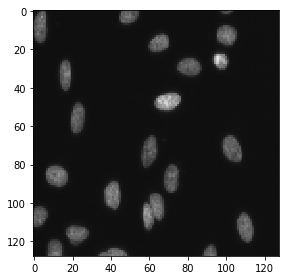

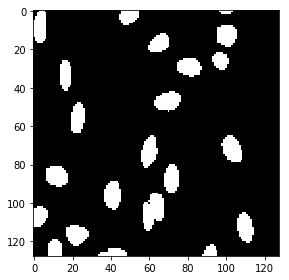

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create the metric

The next part of this task is to implement the [mean average IoU](https://www.kaggle.com/c/data-science-bowl-2018#evaluation) which is essentially a way of characterizing how well our learned mask corresponds to the actual mask.  Note that this is a _metric_ and hence does not actually figure into the backpropogation. For the loss function, we use our trusty binary cross entropy. This is just our classic cross entropy calculation, with only two possible entries per pixel, a mask or no mask. Hence the binary part.

In [17]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Now we build our model based on [dilated convolutions](https://arxiv.org/abs/1511.07122). 

A visualization of this is the following (taken from [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/dilation.gif)):
![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)



In [18]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(21, (3, 3), dilation_rate=1, activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1) (c1)

c2 = Conv2D(21, (3, 3), dilation_rate=1, activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c2 = Dropout(0.1) (c2)

c3 = Conv2D(21, (3, 3), dilation_rate=2, activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c3 = Dropout(0.2) (c3)

c4 = Conv2D(21, (3, 3), dilation_rate=4, activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c4 = Dropout(0.2) (c4)

c5 = Conv2D(21, (3, 3), dilation_rate=8, activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c5 = Dropout(0.3) (c5)

c6 = Conv2D(21, (3, 3), dilation_rate=16, activation='elu', kernel_initializer='he_normal', padding='same') (c5)
c6 = Dropout(0.3) (c6)

c7 = Conv2D(21, (3, 3), dilation_rate=1, activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c7 = Dropout(0.3) (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 21)      588       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 21)      3990      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 21)      3990      
__________

We use [ELUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), which are very closely related to their cousin the RELU. The parameter alpha = 0.3 for keras ELUs, although this can be changed.

We use the following training parameters: a batch size of 16, 50 epochs, and a validation split of 0.1. To make things faster, we could reduce the number of epochs down to 10. Note that we only have about 600 samples, so things go by real fast. For my machine, each epoch ran in 2 minutes or so.

In [19]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 121s 201ms/step - loss: 0.4893 - mean_iou: 0.4139 - val_loss: 0.4680 - val_mean_iou: 0.4298

Epoch 00001: val_loss improved from inf to 0.46798, saving model to model-dsbowl2018-1.h5
Epoch 2/50
603/603 [==============================] - 128s 213ms/step - loss: 0.3778 - mean_iou: 0.4381 - val_loss: 0.2394 - val_mean_iou: 0.4551

Epoch 00002: val_loss improved from 0.46798 to 0.23940, saving model to model-dsbowl2018-1.h5
Epoch 3/50
603/603 [==============================] - 117s 193ms/step - loss: 0.2488 - mean_iou: 0.4843 - val_loss: 0.1900 - val_mean_iou: 0.5143

Epoch 00003: val_loss improved from 0.23940 to 0.19002, saving model to model-dsbowl2018-1.h5
Epoch 4/50
603/603 [==============================] - 121s 200ms/step - loss: 0.1937 - mean_iou: 0.5409 - val_loss: 0.1595 - val_mean_iou: 0.5632

Epoch 00004: val_loss improved from 0.19002 to 0.15954, saving model to model-dsbowl2018-

Our loss decreases systematically. Early stopping is used to prevent overfitting.

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check).

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 5s 73ms/step


In [22]:
ix

315

/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


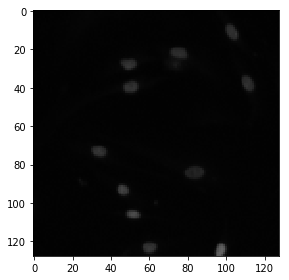

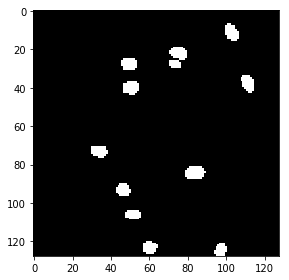

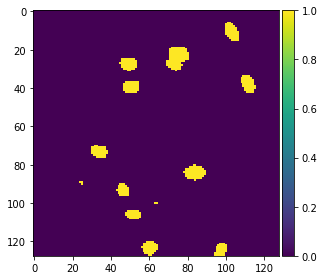

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Azeemdor/.virtualenvs/keras_tf_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


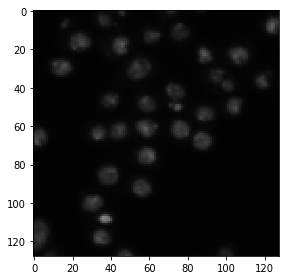

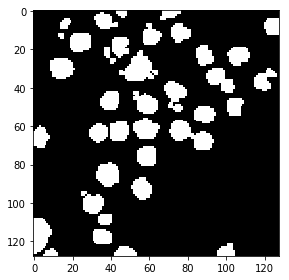

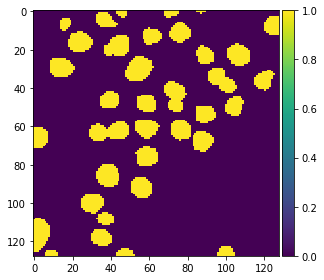

In [24]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

We need to do more training, and also change the architecture.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [25]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [26]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [27]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
print(sub.to_csv('sub-dsbowl2018-1.csv', index=False))

None


This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB